### Import dependencies

In [1]:
from PyAstronomy import pyasl
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from scipy.spatial.transform import Rotation as Rot
from filterpy.kalman import UnscentedKalmanFilter as UKF, MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise
from pyquaternion import Quaternion
import matplotlib.mlab as mlab
from scipy.stats import norm

from numpy.linalg import pinv, inv

import tqdm

from utils import *
import config as c

plt.style.use('plot_style.txt')

device cpu




In [2]:
def q2grp(q, a=1, f=1, wfirst=False):
    if wfirst:
        return f*(q[1:])/(a+q[0])
    else:
        return f*(q[:3])/(a+q[3])
    
def grp2q(x, a, f):
    x_norm_sqrd = np.linalg.norm(x[:3])**2
    scalar = (-a*x_norm_sqrd + f*np.sqrt(f**2+(1-a**2)*x_norm_sqrd))/(f**2+x_norm_sqrd)
    vector = (f**-1) * (a + scalar) * x[:3]
    q = np.zeros(4)
    q[:3] = vector
    q[3] = scalar
    
    q = q / np.linalg.norm(q)
    return q

def qMatrix(q):
    x, y, z, w = q
    A = np.array([[w, z, -y, x], 
                  [-z, w, x, y], 
                  [y, -x, w, z], 
                  [-x, -y, -z, w]])
    return A

def quatmul(qc, qd):
    return qMatrix(qc) @ qd

In [3]:
def fx(x, dt):
    xout = np.empty_like(x) # state = [p, omega]
    grps = x[:3]
    omega = x[3:]

    alphadelta = np.linalg.norm(omega) * dt
    edelta = omega / np.linalg.norm(omega)
    qdelta = np.zeros(4)
    qdelta[:3] = edelta * np.sin(alphadelta/2)
    qdelta[3] = np.cos(alphadelta / 2)    
    
    qmin = grp2q(x, a_const, f_const)
    qplus = quatmul(qmin, qdelta)
    
    xout[:3] = q2grp(qplus, a_const, f_const, False)
    xout[3:] = x[3:]
    
    return xout 

In [4]:
a_const = 1
f_const = 2*(a_const + 1)
seq_len = 100
ts = np.linspace(0,4,seq_len)
dt = ts[0] - ts[1]
eulers = np.array([np.sin(ts), np.sin(ts), np.sin(ts)]).transpose()
dth = np.array([np.cos(ts), np.cos(ts), np.cos(ts)]).transpose()
q_gt =  np.array([Rot.from_euler('xyz', x).as_quat() for x in eulers])
z_q = np.array([Rot.from_euler('xyz', x + np.random.randn(3)*1e-2).as_quat() for x in eulers])
z_grp = np.zeros((seq_len, 3))
for k in range(seq_len):
    z_grp[k] = q2grp(z_q[k],a_const,f_const,False)

In [5]:
def hx(x):
    return x[:3]

100%|██████████| 99/99 [00:00<00:00, 795.14it/s]


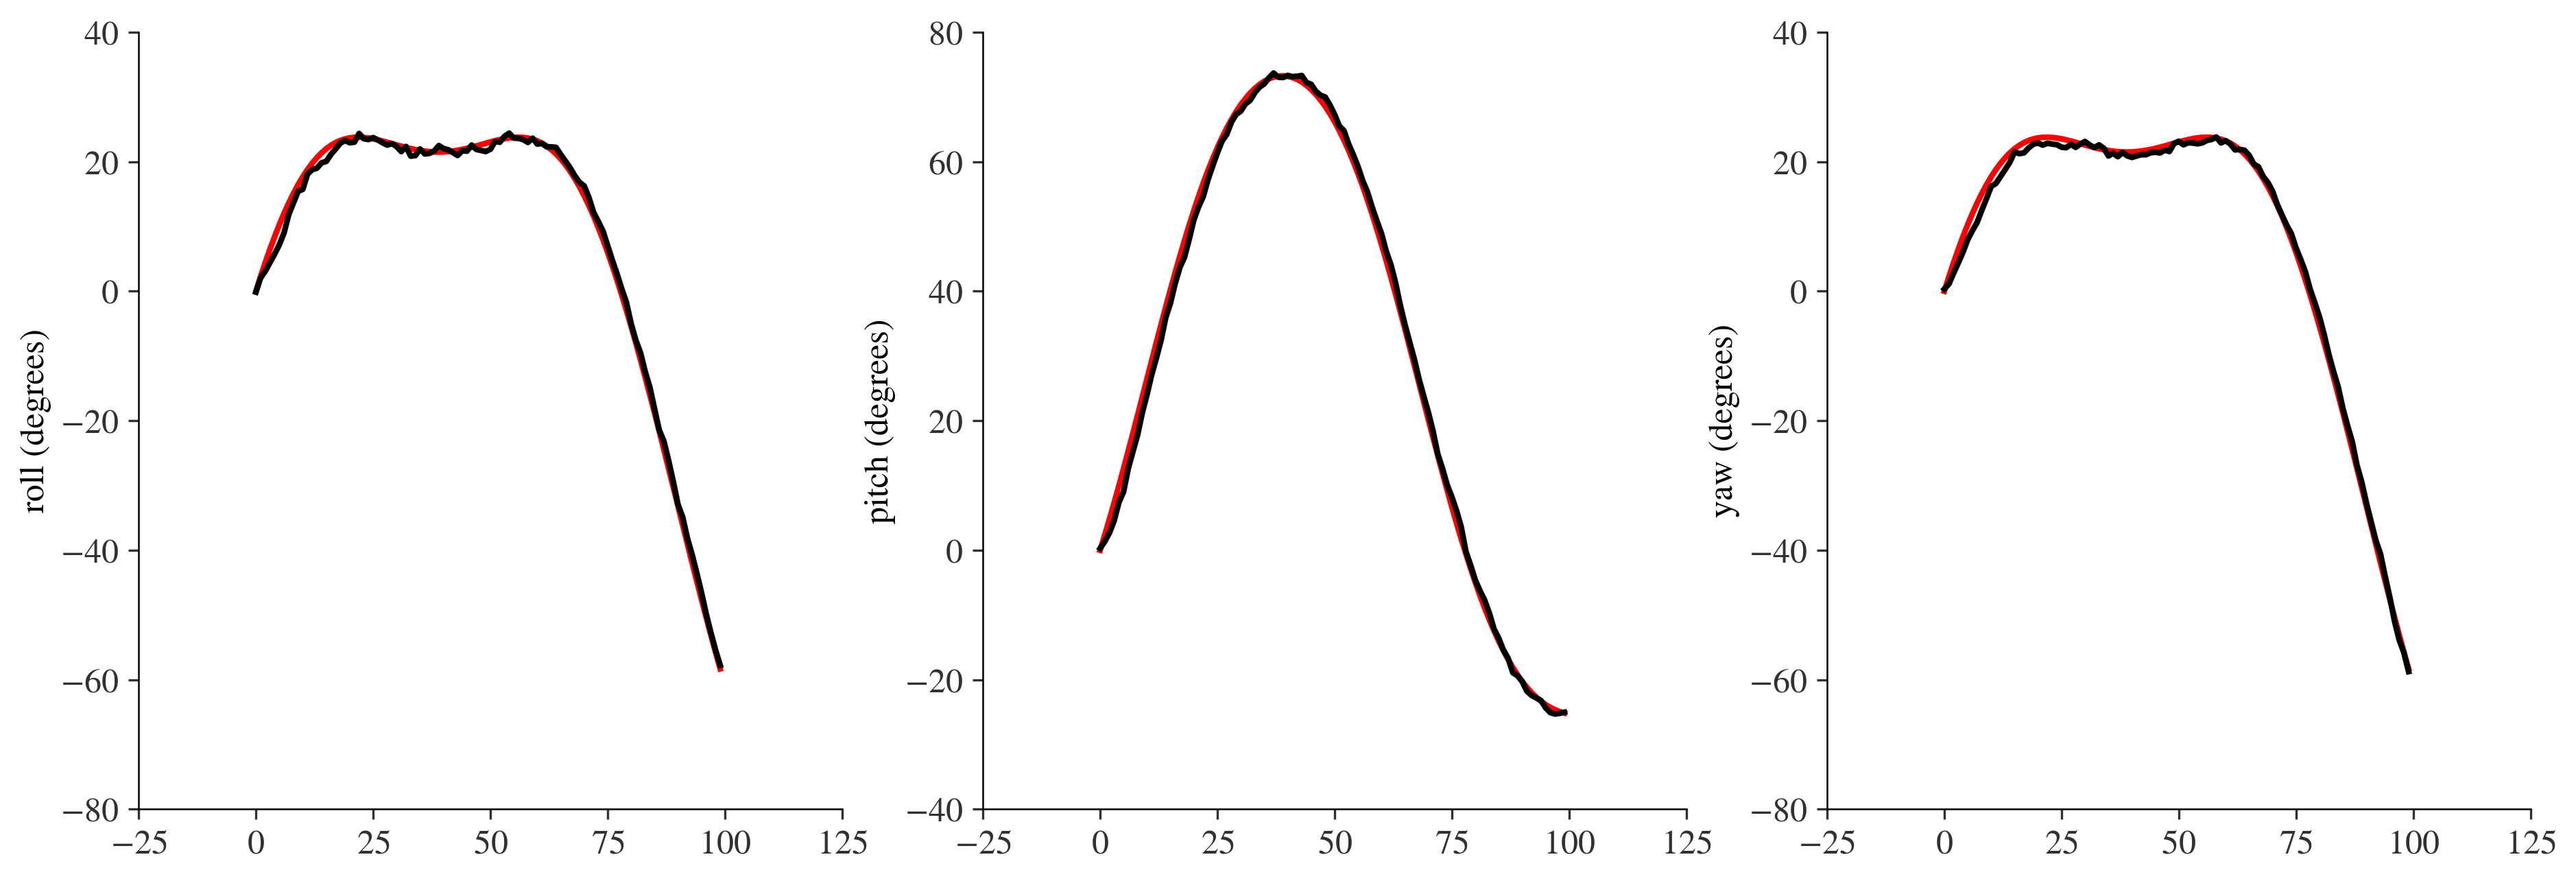

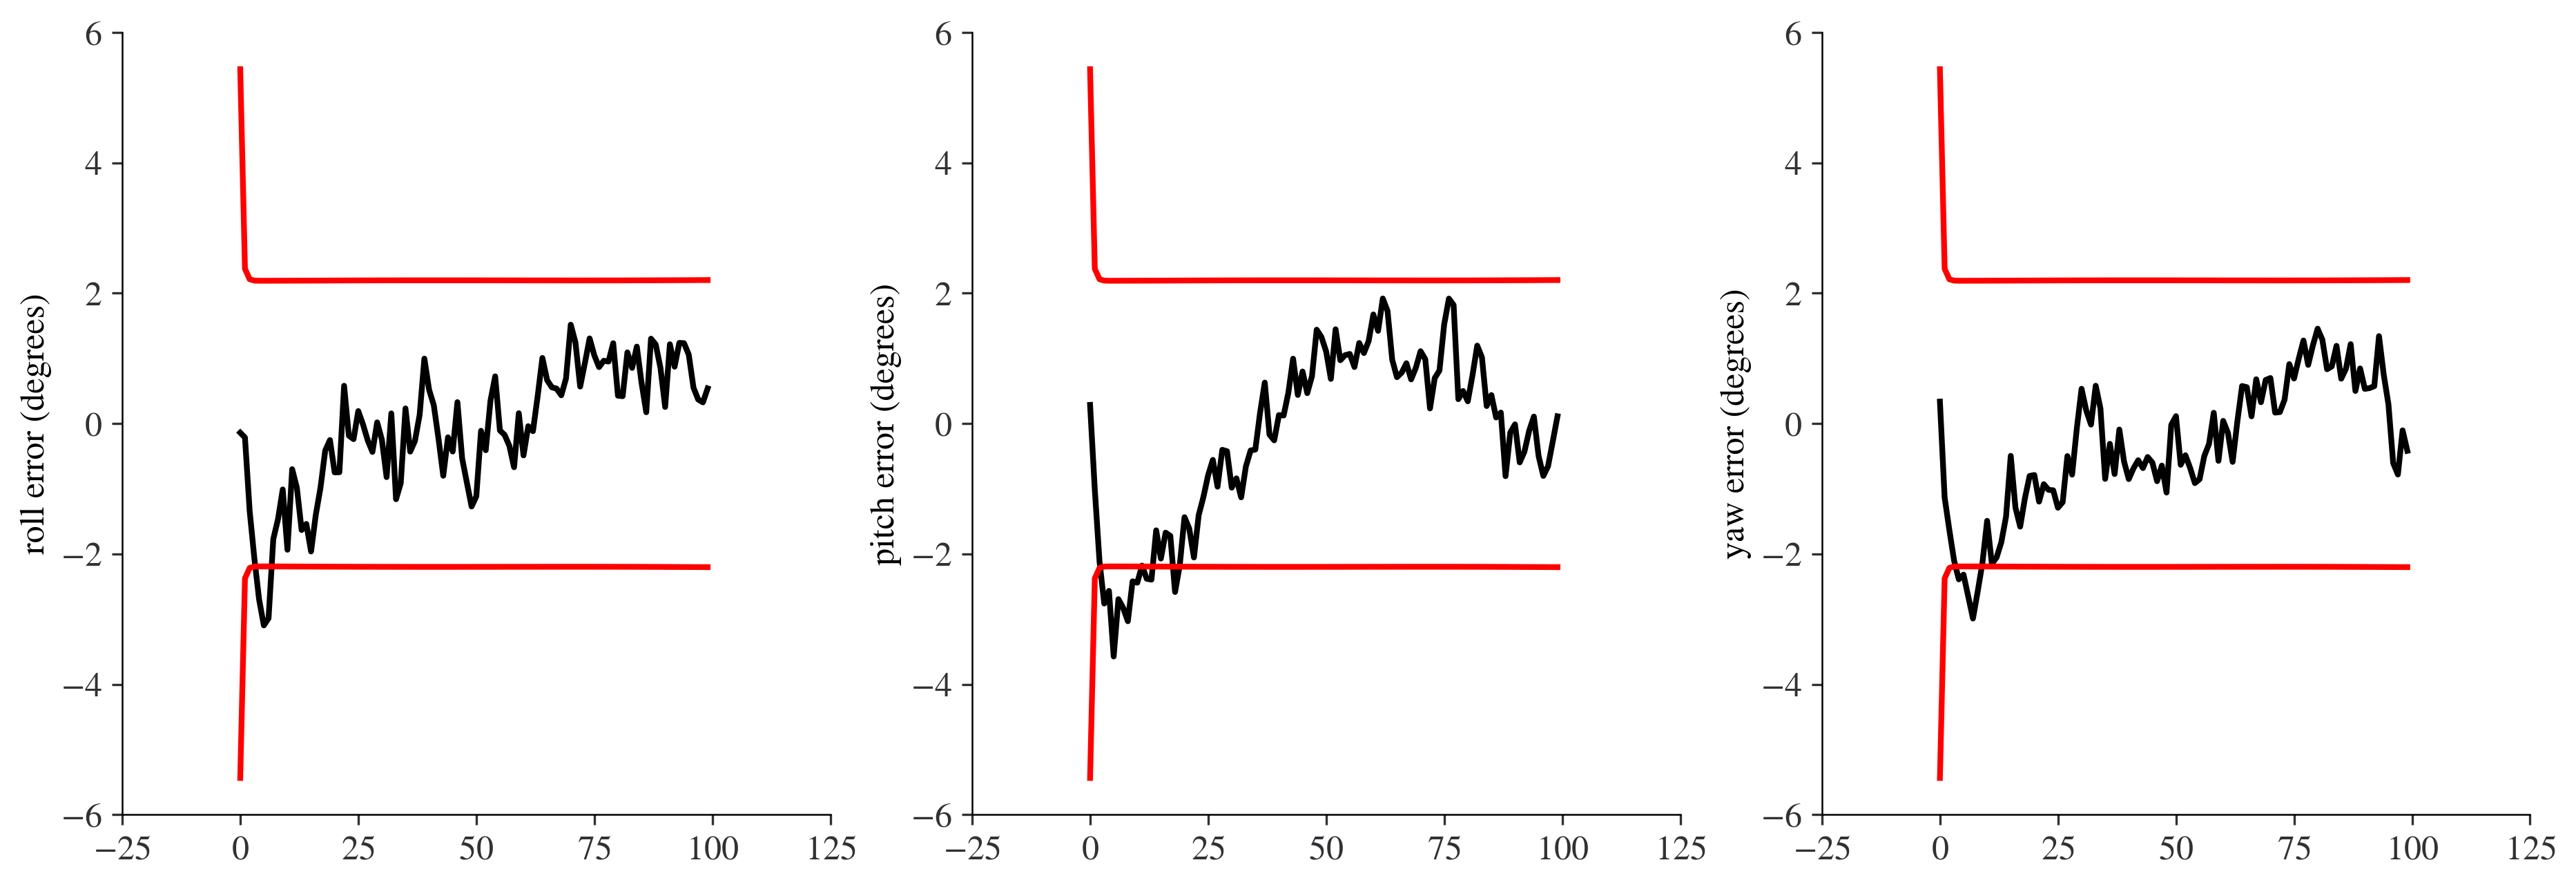

In [6]:
dimx = 6
dimz = 3
points = MerweScaledSigmaPoints(dimx, alpha=.01, beta=2., kappa=-1)
kf = UKF(dim_x=dimx, dim_z=dimz, dt=dt, fx=fx, hx=hx, points=points)
kf.R *= 1e-4
kf.Q *= 1e-4
kf.P *= 1e-3 # initial uncertainty


kf.x[:3] = z_grp[0]
kf.x[3:] = dth[0]
P = np.zeros((seq_len, dimx, dimx))
P[0] = kf.P
xhat = np.zeros((seq_len, dimx))
xhat[0] = kf.x
for t in tqdm.tqdm(range(1,seq_len)):
    kf.predict()
    kf.update(z_grp[t])

    xhat[t] = kf.x
    P[t] = kf.P

z_e = z_grp
e_gt = np.array([q2grp(x[:4], a_const, f_const, False) for x in q_gt])
ehat = xhat[:,:3]
sig = np.array([np.sqrt(x.diagonal()[:3]) for x in P])

e_gt = np.rad2deg(e_gt)
ehat = np.rad2deg(ehat)
sig = np.rad2deg(sig)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,5))

ax1.plot(e_gt[:,0], c='r')
ax1.plot(ehat[:,0], c='k')
ax1.set_ylabel('roll (degrees)')

ax2.plot(e_gt[:,1], c='r')
ax2.plot(ehat[:,1], c='k')
ax2.set_ylabel('pitch (degrees)')

ax3.plot(e_gt[:,2], c='r')
ax3.plot(ehat[:,2], c='k')
ax3.set_ylabel('yaw (degrees)')

plt.show()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,5))
error = (ehat - e_gt)

ax1.plot(sig[:,0]*3, c='r')
ax1.plot(error[:,0], c='k')
ax1.plot(-sig[:,0]*3, c='r')
ax1.set_ylabel('roll error (degrees)')

ax2.plot(sig[:,1]*3, c='r')
ax2.plot(error[:,1], c='k')
ax2.plot(-sig[:,1]*3, c='r')
ax2.set_ylabel('pitch error (degrees)')

ax3.plot(sig[:,2]*3, c='r')
ax3.plot(error[:,2], c='k')
ax3.plot(-sig[:,2]*3, c='r')
ax3.set_ylabel('yaw error (degrees)')

plt.show()

In [7]:
sig[-1] * 3

array([2.20162541, 2.20161478, 2.2016228 ])